# Importing required packages

In [1]:
import numpy as np
import os
from dotenv import load_dotenv
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Declare Constants

In [76]:
DATASET_PATH = "D:\\major-project\\dataset\\archive\\flickr30k_images\\flickr30k_images_processed\\LOW_RES\\"
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
ENCODING_LENGTH = 128
CHANNELS = 3

# Load dataset from Local

In [61]:
data_dir = pathlib.Path(DATASET_PATH)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = None,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode = None,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)


Found 31783 files belonging to 1 classes.
Using 25427 files for training.
Found 31783 files belonging to 1 classes.
Using 6356 files for validation.


### Exploring dataset

In [62]:
print(train_ds)
print(validation_ds)

<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>


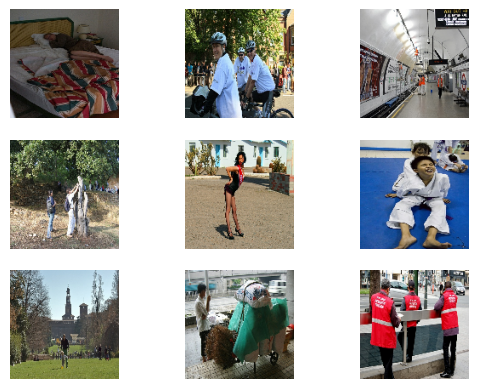

In [63]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Design the model

### Encoder

In [64]:
encoder_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name = "input_img")
x = tf.keras.layers.Rescaling(1./255)(encoder_input)
x = layers.Conv2D(16, 3, activation = 'relu')(x)
x = layers.Conv2D(32, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation = 'relu')(x)
x = layers.Conv2D(ENCODING_LENGTH, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(3)(x)
# x = layers.Conv2D(128, 3, activation = 'relu')(x)
# x = layers.Conv2D(128, 3, activation = 'relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

# create model
encoder = keras.Model(encoder_input, encoder_output, name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 conv2d_31 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 41, 41, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 39, 39, 64)        18496     
                                                           

### Decoder

In [65]:
decoder_input = keras.Input(shape=(128,), name="encodings")
x = layers.Reshape((1, 1, 128))(decoder_input)
x = layers.UpSampling2D(4)(x) #4
x = layers.Conv2DTranspose(32, 3, activation="relu", strides = (3,3))(x) #12
x = layers.Conv2DTranspose(32, 3, activation="relu")(x) #14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides = (3,3))(x) #42
x = layers.UpSampling2D(3)(x) #126
decoder_output = layers.Conv2DTranspose(CHANNELS, 3, activation="sigmoid")(x) #128
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encodings (InputLayer)      [(None, 128)]             0         
                                                                 
 reshape_22 (Reshape)        (None, 1, 1, 128)         0         
                                                                 
 up_sampling2d_48 (UpSamplin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_117 (Conv2  (None, 12, 12, 32)       36896     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_118 (Conv2  (None, 14, 14, 32)       9248      
 DTranspose)                                                     
                                                           

In [70]:
autoencoder_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 128)               97440     
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       56259     
                                                                 
Total params: 153,699
Trainable params: 153,699
Non-trainable params: 0
_________________________________________________________________


# Training

In [71]:
ds_iterator = train_ds.__iter__()
ds = ds_iterator.next().numpy()
for i in range(2):
    batch = ds_iterator.next()
    ds = np.concatenate((ds, batch), axis=0)

In [86]:
autoencoder.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError())
autoencoder.fit(ds,
                ds/255.,
                epochs = 100,
                shuffle = True,
                batch_size = 32)

Epoch 1/100
3/3 [==============================] - 3s 655ms/step - loss: 0.0718
Epoch 2/100
3/3 [==============================] - 2s 641ms/step - loss: 0.0636
Epoch 3/100
3/3 [==============================] - 2s 631ms/step - loss: 0.0605
Epoch 4/100
3/3 [==============================] - 2s 624ms/step - loss: 0.0550
Epoch 5/100
3/3 [==============================] - 2s 629ms/step - loss: 0.0552
Epoch 6/100
3/3 [==============================] - 2s 628ms/step - loss: 0.0507
Epoch 7/100
3/3 [==============================] - 2s 631ms/step - loss: 0.0504
Epoch 8/100
3/3 [==============================] - 2s 625ms/step - loss: 0.0494
Epoch 9/100
3/3 [==============================] - 2s 630ms/step - loss: 0.0483
Epoch 10/100
3/3 [==============================] - 2s 624ms/step - loss: 0.0481
Epoch 11/100
3/3 [==============================] - 2s 632ms/step - loss: 0.0472
Epoch 12/100
3/3 [==============================] - 2s 628ms/step - loss: 0.0470
Epoch 13/100
3/3 [===================

(-0.5, 127.5, 127.5, -0.5)

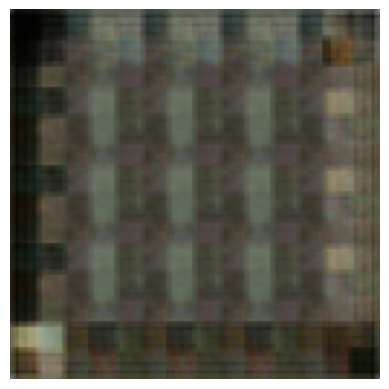

In [87]:
plt.imshow(autoencoder(ds[4].reshape(1, IMG_HEIGHT, IMG_WIDTH, CHANNELS)).numpy().reshape(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
plt.axis("off")